In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import joblib as jb

%matplotlib inline

In [2]:
alphabets = {
    1: 'A',
    2: 'B',
    3: 'C',
    4: 'D',
    5: 'E',
    6: 'F',
    7: 'G',
    8: 'H',
    9: 'I',
    10: 'J',
    11: 'K',
    12: 'L',
    13: 'M',
    14: 'N',
    15: 'O',
    16: 'P',
    17: 'Q',
    18: 'R',
    19: 'S',
    20: 'T',
    21: 'U',
    22: 'V',
    23: 'W',
    24: 'X',
    25: 'Y',
    26: 'Z'
}

In [3]:
def resize_img(image):
    (h,w,d) = image.shape
    ratio = h/w
    # ratio = 295/1599
    nw = 800
    nh = int(nw*ratio)
    
    return (nw, nh)

In [4]:
img = cv2.imread('sample.jpeg')
dimens = resize_img(img)
img = cv2.resize(img, dimens)

<Figure size 640x480 with 0 Axes>

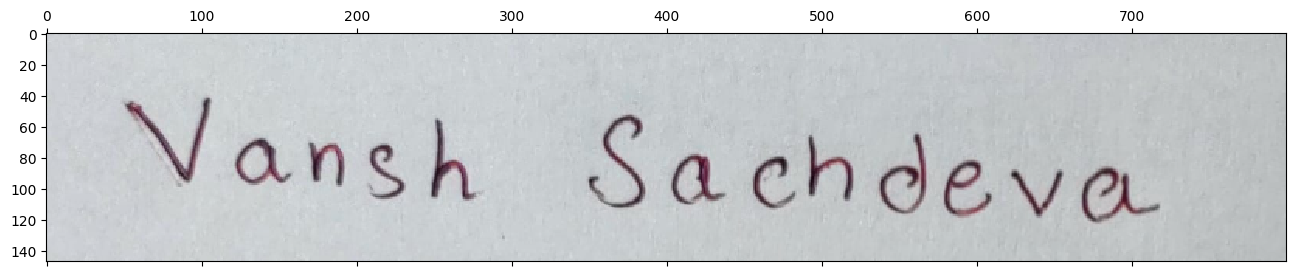

In [5]:
plt.gray()
plt.matshow(img)

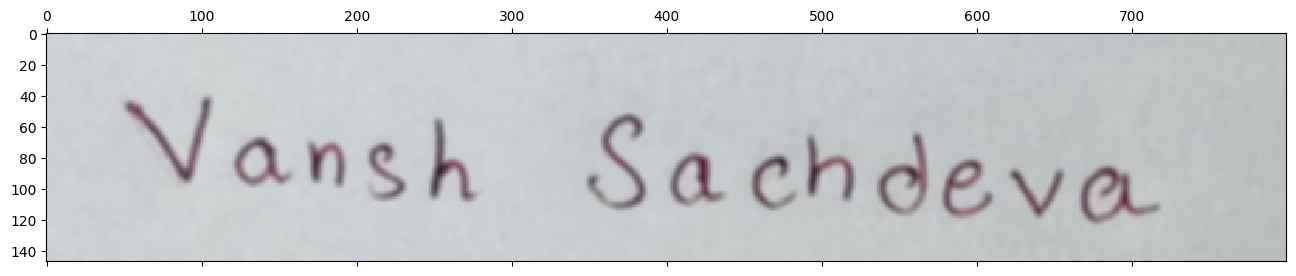

In [6]:
blur = cv2.GaussianBlur(img, (5,5), 10)

plt.matshow(blur)

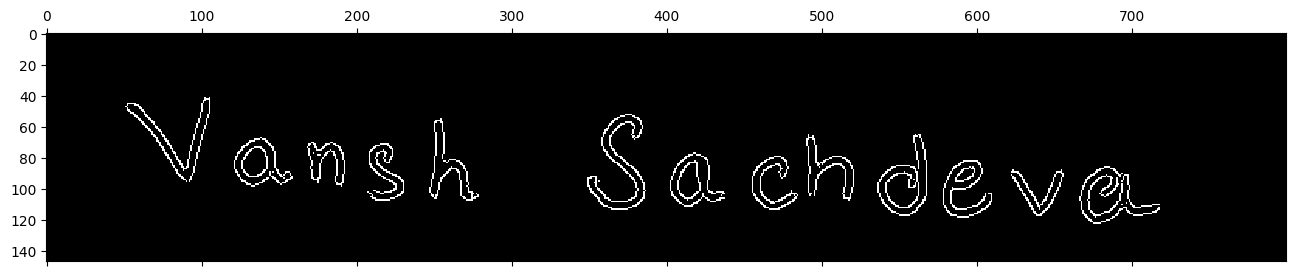

In [7]:
edged = cv2.Canny(blur, 80, 100)

plt.matshow(edged)

In [8]:
model = jb.load('model')

def recognize(arr):
    gray = cv2.cvtColor(arr, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(gray, (28,28))
    transposed = np.transpose(resized)
    bnw = cv2.threshold(transposed, 128, 255, cv2.THRESH_BINARY)[1]
    bnw_inv = cv2.bitwise_not(bnw, bnw)
    final = bnw_inv.reshape(784)

    prediction = model.predict([final])[0]
    return alphabets[prediction]

In [9]:
def sort_arr(arr, subarr):
    swapped = False
    
    n = len(subarr)
    
    for i in range(1, n):
        for j in range(n-i):
            if subarr[j] > subarr[j+1]:
                swapped = True
                subarr[j], subarr[j+1] = subarr[j+1], subarr[j]
                arr[j], arr[j+1] = arr[j+1], arr[j]

In [10]:
def search_space(arr, subarr):
    n = len(subarr)

    s = 0

    for i in range(n-1):
        if subarr[i+1] - subarr[i] > 100:
            arr.insert(i+s+1, ' ')
            s += 1

In [11]:
contours, _ = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

w:  23 h:  28  ----->  O
w:  34 h:  30  ----->  V
w:  52 h:  37  ----->  A
w:  32 h:  37  ----->  E
w:  30 h:  35  ----->  C
w:  36 h:  35  ----->  A
w:  24 h:  37  ----->  Q
w:  25 h:  29  ----->  N
w:  38 h:  32  ----->  A
w:  32 h:  53  ----->  D
w:  31 h:  43  ----->  H
w:  32 h:  53  ----->  H
w:  38 h:  62  ----->  S
w:  55 h:  55  ----->  V


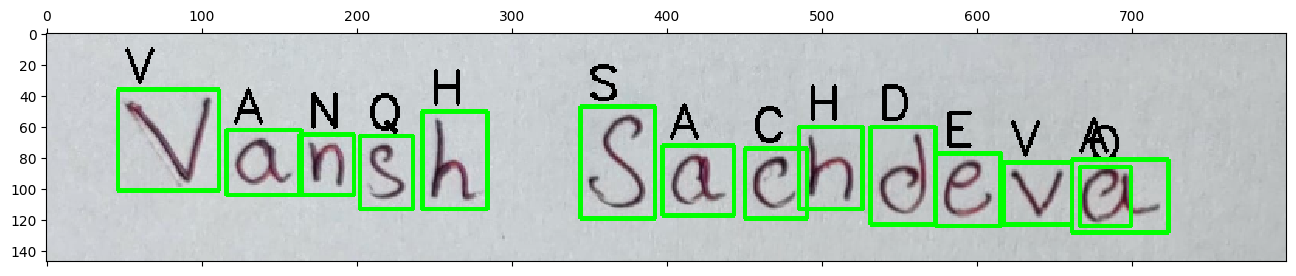

In [12]:
img_copy = img.copy()
text = []
loc = []

for c in contours:
    (x,y,w,h) = cv2.boundingRect(c)
    
    if w>=15 and h>=28:
        cv2.rectangle(img_copy, (x-5,y-5), (x+w+5, y+h+5), (0,255,0), 2)
        input = img[y-10:y+h+10, x-10:x+w+10]
        prediction = recognize(input)
        cv2.putText(img_copy, prediction, (x,y-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 2)

        print('w: ', w, 'h: ', h, ' -----> ', prediction)

        loc.append(x)
        text.append(prediction)


plt.matshow(img_copy)

In [13]:
sort_arr(text, loc)
search_space(text, loc)

''.join(text)

'VANQH SACHDEVAO'